### Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [21]:
# Check if Cuda is running
#torch.cuda.get_device_name(0)

In [22]:
data = pd.read_csv("creditcard.csv")

Let's randomize the data, just to be sure not to get any pathological ordering effects that might harm the performane of Stochastic Gradient Descent.

In [23]:
data = data.reindex(np.random.permutation(data.index))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
124011,77147.0,-1.437314,-0.672735,0.925002,-0.728117,-0.498919,-1.088232,0.098312,0.294362,-1.763211,...,-0.032172,-0.254662,0.569343,0.599137,-0.909906,0.070153,0.017838,0.001861,149.20,0
182926,125586.0,-1.188026,0.648003,0.195708,-2.300317,-1.876858,0.483442,-0.257970,-4.314653,1.394378,...,3.773234,-1.129681,-1.190132,0.066215,0.806729,0.669240,0.580496,0.090244,392.00,0
2807,2364.0,1.571567,-0.852696,-0.411170,-1.735533,-0.574247,-0.298426,-0.606201,-0.165091,-2.384797,...,-0.546954,-1.269700,0.009546,-0.896239,0.433003,-0.425964,0.000977,-0.003500,19.75,0
10848,18552.0,-0.265284,0.081207,1.595559,-1.671107,-0.359368,-0.158713,-0.188054,0.271057,2.710338,...,0.102560,0.673973,0.126516,-0.065758,-1.159539,-1.066871,0.283226,0.230268,11.85,0
250966,155148.0,-1.071928,0.594211,-0.352817,-0.819417,1.439513,0.755137,0.594540,0.448423,0.063034,...,-0.085680,0.088365,0.361190,-0.336159,-1.006584,0.176926,-0.098098,0.001136,14.75,0


In [24]:
data.ndim

2

### Data Analysis

In [6]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.174225e-15,3.429687e-16,-1.386421e-15,2.073779e-15,9.939598e-16,1.493625e-15,-5.931037e-16,1.318317e-16,-2.414318e-15,...,1.416845e-16,-3.515296e-16,2.727492e-16,4.482012e-15,5.203181e-16,1.689590e-15,-3.712632e-16,-1.159267e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
data.isnull().sum().sum()

0

Text(0,0.5,'Frequency')

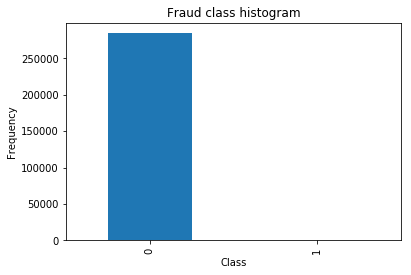

In [8]:
classes = pd.value_counts(data['Class'], sort = True).sort_index()
classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [9]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

#### The Data is hihgly imbalance. 284315 Normal transaction vs 492 Fraud transaction

## 1. Run with Normalising data

In [10]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [11]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [12]:
# Normalising the training data and test data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [13]:
# Fit classifier to a model
classifier = RandomForestClassifier()
classifier.fit(X_train_normalized, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_normalized)

In [15]:
# Making a Confusion Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85287,     4],
       [   45,   107]])

In [16]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.96      0.70      0.81       152

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999427
Area under the curve : 0.851950


## 2. Run with Over Sampling data using SMOTE (Synthetic Minority Over-sampling Technique)

In [17]:
data2 = pd.read_csv("creditcard.csv")

In [18]:
from sklearn.preprocessing import StandardScaler

data2['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data2 = data2.drop(['Time','Amount'],axis=1)
data2.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.349671
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.349231
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.127897
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.053373
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.221892


In [19]:
X = np.array(data.ix[:, data.columns != 'Class'])
y = np.array(data.ix[:, data.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 30)
Shape of y: (284807, 1)


In [20]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print('xtrain shape')
print(X_train.shape)
print('xtest shape')
print(X_test.shape)

xtrain shape
(199364, 30)
xtest shape
(85443, 30)


In [21]:
# Over Sampling data using SMOTE
smote = SMOTE(random_state=2)
X_train_resample, y_train_resample = smote.fit_sample(X_train, y_train.ravel())

In [22]:
classifier = RandomForestClassifier()
classifier.fit(X_train_resample, y_train_resample.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [24]:
# Making a Confision Matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm

Confusion Matrix


array([[85274,    17],
       [   26,   126]])

In [25]:
print('Classification Report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy : %f' % (metrics.accuracy_score(y_test, y_pred)))
print('Area under the curve : %f' % (metrics.roc_auc_score(y_test, y_pred)))

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85291
          1       0.88      0.83      0.85       152

avg / total       1.00      1.00      1.00     85443

Accuracy : 0.999497
Area under the curve : 0.914374


## 3. Run with Generative Adversarial Networks (GANs)

In [2]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#data = pd.read_csv("creditcard.csv")
#data.drop(['Time'], axis = 1, inplace = True)
#data.drop(['Class'], axis = 1, inplace = True)

In [4]:
data3 = pd.read_csv("creditcard.csv")

In [5]:
from sklearn.preprocessing import StandardScaler

data3['normAmount'] = StandardScaler().fit_transform(data3['Amount'].values.reshape(-1, 1))
data3 = data3.drop(['Time','Amount'],axis=1)
data3.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [6]:
X = np.array(data3.ix[:, data3.columns != 'Class'])
y = np.array(data3.ix[:, data3.columns == 'Class'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (284807, 29)
Shape of y: (284807, 1)


In [7]:
from torch.autograd import Variable
X = Variable(torch.FloatTensor(X))
y = Variable(torch.FloatTensor(y))

In [8]:
# Generator's paragrams
g_input_size = 29     # Random noise dimension
g_hidden_size = 50   # Generator complexity
g_output_size = 1   
g_learning_rate = 0.0002
g_steps = 1

#Discriminator's paragrams
d_input_size = 29   # Minibatch size
d_hidden_size = 50  # Discriminator complexity
d_output_size = 1   # Single dimension for 'real' vs. 'fake'
d_learning_rate = 0.0002
d_steps = 1 

minibatch_size = d_input_size

num_epochs = 2000
print_interval = 10

In [9]:
# Generator
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # ELU (Exponential Linear Unit) function tends to converge cost to zero faster and produce more accurate results
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        return self.map3(x)

In [10]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.map1(x)
        x = F.elu(x)
        x = self.map2(x)
        x = F.elu(x)
        x = self.map3(x)
        return F.sigmoid(x)

In [11]:
def extract(v):
    return v.data.storage().tolist()

In [12]:
def stats(d):
    return [np.mean(d), np.std(d)]

In [13]:
generator = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
discriminator = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

In [14]:
def plot(disc):
    h=0.1
    x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
    y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    x_test = np.c_[xx.ravel(), yy.ravel()]
    y_hat_test = disc.forward_with_sigmoid(Variable(torch.from_numpy(x_test).float()))

    plt.pcolormesh(xx, yy, y_hat_test.data.numpy().reshape(xx.shape), cmap=plt.cm.Paired)
    plt.colorbar()
    plt.scatter(x[:, 0], x[:, 1], c=y*20, alpha=0.1, cmap=plt.cm.flag, s=2)
    plt.show()

In [15]:
# Use Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

In [16]:
# Set the optimizers
beta_1 = 0.5
beta_2 = 0.999
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate/2, betas=(beta_1, beta_2))
g_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(beta_1, beta_2))

In [17]:
# Training GANs
for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Updating the weights of the Discriminator
        discriminator.zero_grad() # Initialize gradients of the Discriminator to 0

        # Training the Discriminator with real data
        d_real_data = Variable(X[0]) # Wrap it in a variable
        d_real_decision = discriminator(d_real_data) # Forward propagate this real data into the neural network
        #target = Variable(torch.ones(input.size()[0]))
        y_real = Variable(torch.ones(1)) # Get the target
        d_real_loss = BCE_loss(d_real_decision, y_real) # Compute the loss between the prediction and actual
        d_real_loss.backward() # Compute/store gradients
    
        # Train the Discriminator with a fake data generated by the Generator
        #d_gen_input = Variable(torch.randn(minibatch_size, 29))
        d_gen_input = Variable(torch.randn(minibatch_size, g_input_size))
        d_fake_data = generator(d_gen_input).detach()  # detach to avoid training G on these labels
        
        d_fake_decision = discriminator(d_fake_data.t())
        y_fake = Variable(torch.zeros(1))
        d_fake_loss = BCE_loss(d_fake_decision, y_fake)  # zeros = fake
        d_fake_loss.backward()
        d_optimizer.step()     # Apply SGD to update the weight
        
    for g_index in range(g_steps):
        # 2. Update the weight of the Generator 
        generator.zero_grad()

        gen_input = Variable(torch.randn(minibatch_size, g_input_size))
        g_fake_data = generator(gen_input)
        dg_fake_decision = discriminator(g_fake_data.t())
        target = Variable(torch.ones(1))
        g_loss = BCE_loss(dg_fake_decision, target)
        g_loss.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
    if epoch % print_interval == 0:
        print("%s: Discriminator: Real Loss %s / Fake Loss %s Generator: %s (Real Data: %s, Fake Data: %s) " % (epoch,
                                                            extract(d_real_loss)[0],
                                                            extract(d_fake_loss)[0],
                                                            extract(g_loss)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))


0: Discriminator: Real Loss 0.7146553993225098 / Fake Loss 0.7263058423995972 Generator: 0.6550813317298889 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.12243700669757251, 0.040750250465088109]) 
10: Discriminator: Real Loss 0.6888497471809387 / Fake Loss 0.7304084897041321 Generator: 0.6586706042289734 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.18390269166436687, 0.030512922292892389]) 
20: Discriminator: Real Loss 0.6655375957489014 / Fake Loss 0.7197965979576111 Generator: 0.6639719009399414 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.23001699714825072, 0.026241669274155541]) 
30: Discriminator: Real Loss 0.6435287594795227 / Fake Loss 0.7123153805732727 Generator: 0.6772176027297974 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.23986404106534762, 0.037057275082252858]) 
40: Discriminator: Real Loss 0.6217685341835022 / Fake Loss 0.7084786891937256 Generator: 0.682263553

370: Discriminator: Real Loss 0.06519893556833267 / Fake Loss 0.2733074128627777 Generator: 1.3107383251190186 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.31445636882864197, 0.057748057041549922]) 
380: Discriminator: Real Loss 0.061326052993535995 / Fake Loss 0.2544025778770447 Generator: 1.3364758491516113 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.26283326847799893, 0.057419521438375032]) 
390: Discriminator: Real Loss 0.05728227272629738 / Fake Loss 0.27676087617874146 Generator: 1.5549992322921753 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.090360234266725084, 0.044396219337699744]) 
400: Discriminator: Real Loss 0.053298093378543854 / Fake Loss 0.29470133781433105 Generator: 1.2872024774551392 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.053964807427135005, 0.057760846595318271]) 
410: Discriminator: Real Loss 0.04939259588718414 / Fake Loss 0.31965601444244385 Gen

730: Discriminator: Real Loss 0.008537814021110535 / Fake Loss 0.0806964859366417 Generator: 2.6558971405029297 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.3128200985234359, 0.074114109994879745]) 
740: Discriminator: Real Loss 0.008258013986051083 / Fake Loss 0.07927320152521133 Generator: 2.6270949840545654 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.28350005941144352, 0.082445532367532104]) 
750: Discriminator: Real Loss 0.007965495809912682 / Fake Loss 0.06457023322582245 Generator: 2.6787774562835693 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.18609104735841012, 0.06948457029027022]) 
760: Discriminator: Real Loss 0.007681231014430523 / Fake Loss 0.058009132742881775 Generator: 2.511039972305298 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.097156465567391492, 0.065867805249533701]) 
770: Discriminator: Real Loss 0.007378853391855955 / Fake Loss 0.07794021815061569 Gen

1090: Discriminator: Real Loss 0.002491953782737255 / Fake Loss 0.04254743829369545 Generator: 3.1544947624206543 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.33939043021407622, 0.10271701251204628]) 
1100: Discriminator: Real Loss 0.0024059724528342485 / Fake Loss 0.01830277219414711 Generator: 3.4808242321014404 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.3545136009824687, 0.10916457909368471]) 
1110: Discriminator: Real Loss 0.0023268689401447773 / Fake Loss 0.0318559892475605 Generator: 3.367393732070923 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.32043149604879578, 0.106934876920594]) 
1120: Discriminator: Real Loss 0.002252311911433935 / Fake Loss 0.020933208987116814 Generator: 3.813209295272827 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.33445675902325533, 0.12297978145031713]) 
1130: Discriminator: Real Loss 0.0021842713467776775 / Fake Loss 0.0268489867448806

1450: Discriminator: Real Loss 0.0011322945356369019 / Fake Loss 0.011697896756231785 Generator: 3.585561513900757 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [-0.030251227190782284, 0.13382754665050134]) 
1460: Discriminator: Real Loss 0.0011138560948893428 / Fake Loss 0.015780555084347725 Generator: 4.37075138092041 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.023289885757298304, 0.14888761696741507]) 
1470: Discriminator: Real Loss 0.0010988786816596985 / Fake Loss 0.012399665080010891 Generator: 3.9528937339782715 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.17914857728214101, 0.17898358410469983]) 
1480: Discriminator: Real Loss 0.0010952985612675548 / Fake Loss 0.004264805931597948 Generator: 4.474221706390381 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.21093847512685018, 0.18895072278633748]) 
1490: Discriminator: Real Loss 0.0010869447141885757 / Fake Loss 0.0317823179

1810: Discriminator: Real Loss 0.0006785310106351972 / Fake Loss 0.007482318673282862 Generator: 4.5476250648498535 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.090327410348530479, 0.17063767746509845]) 
1820: Discriminator: Real Loss 0.0006708964356221259 / Fake Loss 0.019936785101890564 Generator: 4.245009422302246 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.16468341365970415, 0.184225388978903]) 
1830: Discriminator: Real Loss 0.0006658266647718847 / Fake Loss 0.012896995060145855 Generator: 4.572345733642578 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.20950404060041083, 0.13888944554201338]) 
1840: Discriminator: Real Loss 0.0006647530826739967 / Fake Loss 0.008260934613645077 Generator: 5.349987983703613 (Real Data: [-3.6094789557106026e-11, 1.0460391654253318], Fake Data: [0.23056189715862274, 0.14274773957232181]) 
1850: Discriminator: Real Loss 0.0006627251859754324 / Fake Loss 0.0075953169725

In [18]:
extract(d_real_loss)

[0.0005735611193813384]